# Predicting Airline Delays

## Airline On-Time Statistics and Delay Causes
### The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS) tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled and diverted flights appears in DOT's monthly Air Travel Consumer Report, published about 30 days after the month's end, as well as in summary tables posted on this website. Summary statistics and raw data are made available to the public at the time the Air Travel Consumer Report is released.

### Here we will look at 2008 data and see if can predict the flights being late. For this analysis we assume a flight only counts as late if it arrives or departs more than 30 minutes later than scheduled. 

### Source: http://stat-computing.org/dataexpo/2009/the-data.html

<h7> Shahab Athari, Principal Analyst for Control and Economic Analysis in Equinor.com located in Houston, Texas.</h7> 

In [4]:
#Import Python libraries that will be used in this model
%matplotlib inline
from collections import OrderedDict
from datetime import datetime
from IPython.display import Image
from scipy.stats import randint as sp_randint
from sklearn.datasets import make_classification
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing, decomposition
from sklearn import tree
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA as sklearn_pca
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.grid_search import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,cross_val_score, KFold, cross_val_predict
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import random
import scipy
import seaborn as sns
import sklearn
import sklearn.cross_validation 
import sklearn.tree
import time
import timeit
import warnings 
warnings.simplefilter('ignore')

In [5]:
path1 = ("C:/Users/aath/Dropbox/MAEN/DS/data/airline/2008.csv")
n = sum(1 for line in open(path1)) - 1 #number of records in file (excludes header)
s = 150000 #desired sample size
s_small = 5000 # extra small sample size for few computationaly intensive models
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
raw = pd.read_csv(path1, skiprows=skip)
raw.head(10)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,1426.0,1430,1426.0,1425,WN,829,...,9.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,1954.0,1925,2239.0,2235,WN,1754,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,1538.0,1445,1753.0,1710,WN,500,...,4.0,11.0,0,NaN,0,15.0,0.0,0.0,0.0,28.0
3,2008,1,3,4,655.0,655,742.0,750,WN,731,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1003.0,1005,1208.0,1215,WN,871,...,5.0,11.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5,2008,1,3,4,1657.0,1630,1905.0,1845,WN,3517,...,5.0,14.0,0,NaN,0,2.0,0.0,0.0,0.0,18.0
6,2008,1,3,4,1415.0,1350,1527.0,1510,WN,3835,...,4.0,12.0,0,NaN,0,9.0,0.0,0.0,0.0,8.0
7,2008,1,3,4,1613.0,1515,1727.0,1615,WN,2363,...,3.0,24.0,0,NaN,0,0.0,0.0,19.0,0.0,53.0
8,2008,1,3,4,1712.0,1555,1935.0,1820,WN,1585,...,4.0,17.0,0,NaN,0,0.0,0.0,6.0,0.0,69.0
9,2008,1,3,4,2105.0,2025,2342.0,2310,WN,361,...,6.0,9.0,0,NaN,0,0.0,0.0,11.0,0.0,21.0


In [6]:
print('Total rows of data:', n)
print('Dataframe dimensions:', raw.shape)

Total rows of data: 7009728
Dataframe dimensions: (150000, 29)


In [7]:
df = raw.copy() # Copy into a new dataframe

In [8]:
# See the unique number of Origins and Airlines
print("Total number of unique Carriers: {}. ".format(df['UniqueCarrier'].nunique())) 
print("Total number of unique Origins: {}. ".format(df['Origin'].nunique())) 

Total number of unique Carriers: 20. 
Total number of unique Origins: 297. 


In [9]:
# Check the completness of the dataset; showing top ones
null_df = df.isnull().sum(axis=0).reset_index()
null_df.columns = ['variable', 'missing values']
null_df['filling factor (%)']=(df.shape[0]-null_df['missing values'])/df.shape[0]*100
null_df.sort_values('filling factor (%)').reset_index(drop = True).head(18)

,variable,missing values,filling factor (%)
0,CancellationCode,147076,1.949333
1,LateAircraftDelay,117404,21.730667
2,NASDelay,117404,21.730667
3,WeatherDelay,117404,21.730667
4,CarrierDelay,117404,21.730667
5,SecurityDelay,117404,21.730667
6,AirTime,3304,97.797333
7,ActualElapsedTime,3304,97.797333
8,ArrDelay,3304,97.797333
9,ArrTime,3237,97.842000


CancellationCode has the largest missing value and we will drop it here. Next five columns miss more than 80% of their values. And since all of these are related to delays we use columns mean values to fill the missing values.

In [10]:
df = df.drop(['CancellationCode'], axis = 1)
df = df.reset_index(drop=True)
df = df.fillna(df.mean())
df = df.reset_index(drop=True)

In [11]:
# Check the completness of the dataset; showing top ones
null_df = df.isnull().sum(axis=0).reset_index()
null_df.columns = ['variable', 'missing values']
null_df['filling factor (%)']=(df.shape[0]-null_df['missing values'])/df.shape[0]*100
null_df.sort_values('filling factor (%)').reset_index(drop = True).head()

,variable,missing values,filling factor (%)
0,TailNum,1816,98.789333
1,Year,0,100.000000
2,NASDelay,0,100.000000
3,WeatherDelay,0,100.000000
4,CarrierDelay,0,100.000000


In [12]:
df = df.dropna()     #drop all rows that have any NaN value

In [13]:
# Check the completness once more
null_df = df.isnull().sum(axis=0).reset_index()
null_df.columns = ['variable', 'missing values']
null_df['filling factor (%)']=(df.shape[0]-null_df['missing values'])/df.shape[0]*100
null_df.sort_values('filling factor (%)').reset_index(drop = True).head(3)

,variable,missing values,filling factor (%)
0,Year,0,100.0
1,NASDelay,0,100.0
2,WeatherDelay,0,100.0


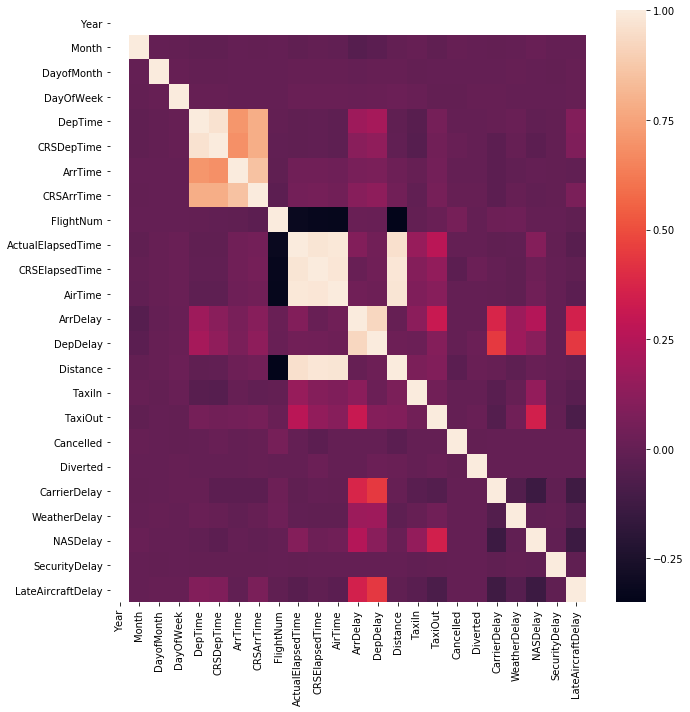

In [14]:
# By using correlation matrix we can start identifying factors that can help to predict lateness  
correlation_mat = df.corr()

#Plot heatmap
plt.figure(figsize=(10, 10))
ax = sns.heatmap(correlation_mat)  # use this if want text added to each box annot=True
plt.tight_layout()
plt.show()

In [15]:
# Drop variables which do not have correlation with arrival delays/cannot be predicted until the flight
df.drop(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightNum',
         'Cancelled', 'Diverted', 'SecurityDelay'],axis=1, inplace=True)
df = df.reset_index(drop=True)

In [16]:
# Check the data type of each column by groupby
df.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['CRSDepTime', 'CRSArrTime', 'Distance'], dtype='object'),
 dtype('float64'): Index(['DepTime', 'ArrTime', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime',
        'ArrDelay', 'DepDelay', 'TaxiIn', 'TaxiOut', 'CarrierDelay',
        'WeatherDelay', 'NASDelay', 'LateAircraftDelay'],
       dtype='object'),
 dtype('O'): Index(['UniqueCarrier', 'TailNum', 'Origin', 'Dest'], dtype='object')}

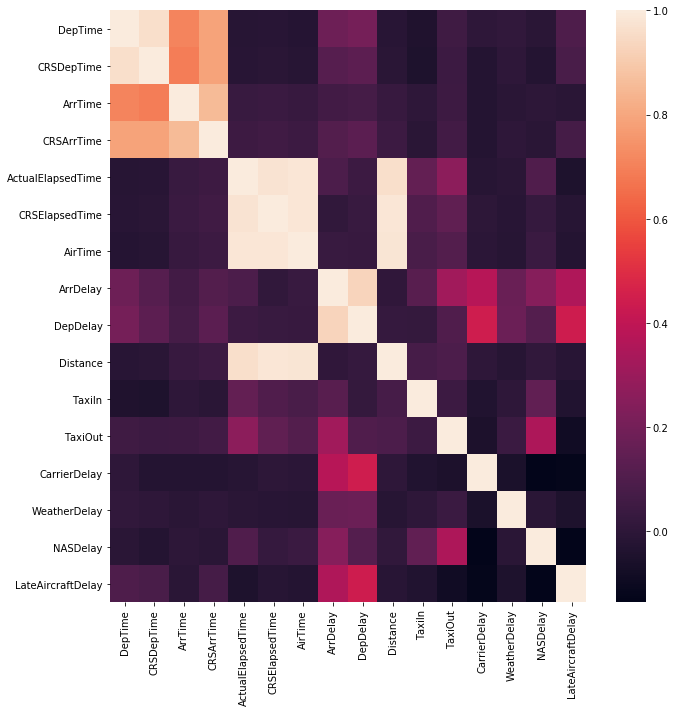

In [17]:
# Revisit the heatmap once more
# By using correlation matrix we can start identifying factors that can help to predict lateness  
correlation_mat = df.corr()

#Plot heatmap
plt.figure(figsize=(10, 10))
ax = sns.heatmap(correlation_mat)  # use this if want text added to each box annot=True
plt.tight_layout()
plt.show()

In [18]:
# Convert to float
df[['CRSDepTime', 'CRSArrTime', 'CRSElapsedTime','Distance']] = df[['CRSDepTime', 
                  'CRSArrTime', 'CRSElapsedTime', 'Distance']].values.astype(float)

In [19]:
# Sample view after grouping and aggreating delay values for some airlines. 
df.groupby(['Origin'])\
                      .agg({'ArrDelay':['min', 'max', 'mean', 'count'],
                            'DepDelay':['min', 'max', 'mean']}).head(10)

ArrDelay                         DepDelay                  
            min    max       mean count      min    max       mean
Origin                                                            
ABE       -44.0  291.0  14.271865   122    -12.0  287.0  11.614901
ABI       -26.0  248.0   3.072464    69    -13.0  250.0   5.362319
ABQ       -41.0  172.0   2.818627   861    -17.0  180.0   5.709682
ABY       -24.0  139.0  17.862069    29    -10.0  102.0  17.620690
ACK       -25.0  106.0  19.616750    10     -5.0  118.0  29.301791
ACT       -17.0  113.0   7.329187    40    -11.0  122.0   8.925448
ACV       -27.0  160.0  10.333352    91    -16.0  151.0  12.110284
ACY        -8.0   24.0   4.333333     3     -1.0   41.0  13.666667
ADQ       -26.0  315.0  20.474423    13    -15.0  307.0  23.924454
AEX       -16.0  161.0  15.539042    47    -10.0  166.0  14.447570

In [20]:
# Define lateness as 30 minitues or more lateness beyond scheduled arrival time
df['ArrLate'] =  df['ArrDelay'].apply(lambda x: 0 if x<30 else 1)

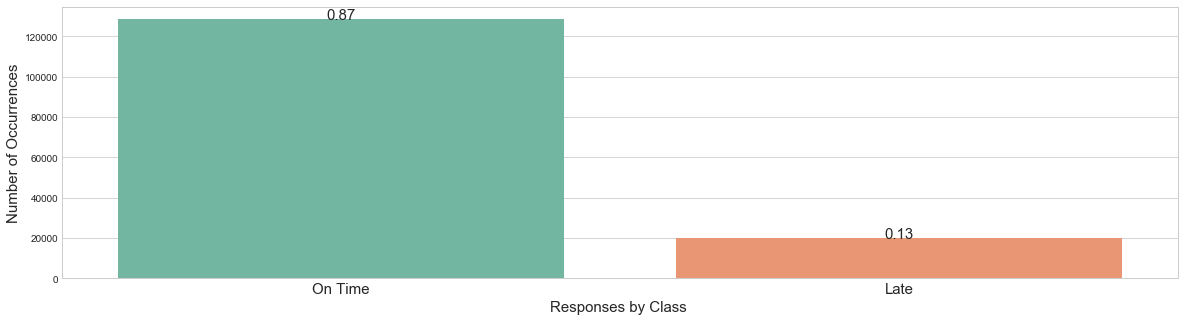

In [21]:
# To show any imbalance 
plt.figure(figsize=(20, 5))
fontsize = 15
sns.set_style("whitegrid")
plt.subplot(1, 1, 1)
ax = sns.countplot(x="ArrLate", data=df, palette="Set2")
ax.set_xlabel('Responses by Class ',fontsize=fontsize)
ax.set_ylabel('Number of Occurrences',fontsize=fontsize)
ax.set_xticklabels(['On Time','Late'], fontsize=fontsize)

# Use below function to calcualte the percentage for each bar
total = float(len(df)) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),fontsize=fontsize, ha="center") 
    
#plt.ylim(0, 50000) # Use this if want to show a subset of all data

In [22]:
# Copy into new dataframe so can do side calculation for identifying important airlines
df1 = df.copy()

In [23]:
# To identify the most important airlines with biggest numbers of late arrivals
df2=df1[df1['ArrLate']==1]                          # Filter the dataset where Arrivale Late = 30 or more
df3=df2.groupby(['UniqueCarrier'])                  # Group by airlines
df4 = df3['ArrLate'].count()                        # Count
df5=df4.sort_values(ascending=False)                # Sort
df6=df5.reset_index()                               # Reset the index
df6['cum_sum'] = df6.ArrLate.cumsum()               # Calculate the cumulative
df6['cum_perc'] = 100*df6.cum_sum/df6.ArrLate.sum() # Calculate the percentage cumulative
df6 = df6[df6.cum_perc < 90]                        # Keep only those explain up to 90% of cume%
df6

,UniqueCarrier,ArrLate,cum_sum,cum_perc
0,WN,2785,2785,14.072053
1,AA,2183,4968,25.102319
2,UA,1671,6639,33.545551
3,MQ,1557,8196,41.412763
4,OO,1452,9648,48.749432
5,XE,1225,10873,54.939114
6,DL,1131,12004,60.653833
7,CO,974,12978,65.575261
8,US,968,13946,70.466374
9,NW,929,14875,75.160426


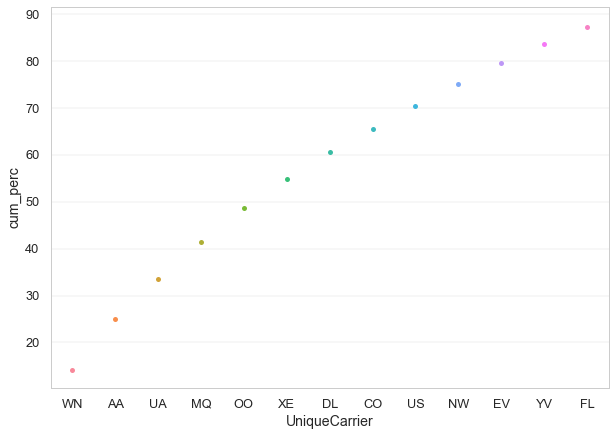

In [24]:
# Show cumulative number of late arrivals per airlines
fig = plt.figure(1, figsize=(10,7))
sns.set_context("poster", font_scale = .8, rc={"grid.linewidth": 0.3})
ax = sns.stripplot(y=df6['cum_perc'], x=df6['UniqueCarrier'])

In [25]:
# Remove minor airlines to make the dataset lighter
main_airlines = list(df6.UniqueCarrier) # Identify main airlines
df1=df1[df1['UniqueCarrier'].isin(main_airlines)] # Filter away minor airlines

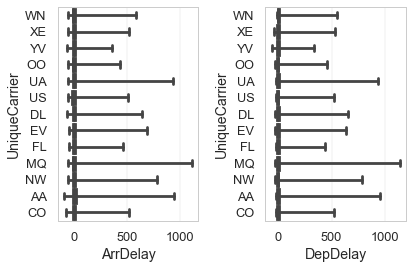

In [26]:
# Show arrival and departure delays per airlines
plt.subplot(1, 2, 1)
fig = plt.figure(1, figsize=(10,10))
sns.set_context("poster", font_scale = .8, rc={"grid.linewidth": 0.3})
ax = sns.boxplot(y=df1['UniqueCarrier'], x=df1['ArrDelay'], whis=np.inf)

plt.subplot(1, 2, 2)
fig = plt.figure(1, figsize=(10,10))
sns.set_context("poster", font_scale = .8, rc={"grid.linewidth": 0.3})
ax = sns.boxplot(y=df1['UniqueCarrier'], x=df1['DepDelay'], whis=np.inf)
plt.tight_layout()

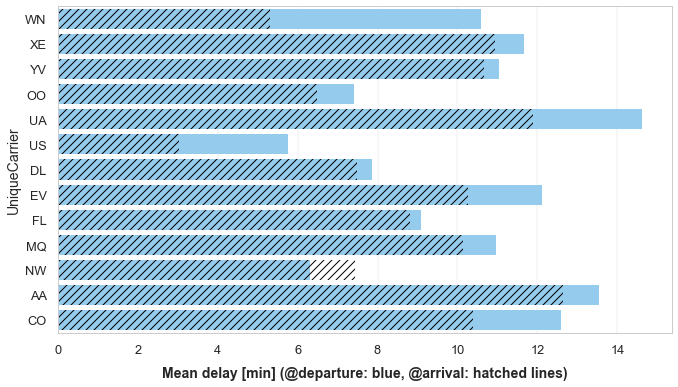

In [27]:
# Showing mean delays both for arrivals and departures 

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DepDelay", y="UniqueCarrier", data=df1, color="lightskyblue", ci=None)
ax = sns.barplot(x="ArrDelay", y="UniqueCarrier", data=df1, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
#ax.set_yticklabels(labels)
#ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatched lines)',
           fontsize=14, weight = 'bold', labelpad=10);

In [28]:
# Now let's go back to previous dataframe df and eliminate minor airlines
df=df[df['UniqueCarrier'].isin(main_airlines)] # Filter away minor airline

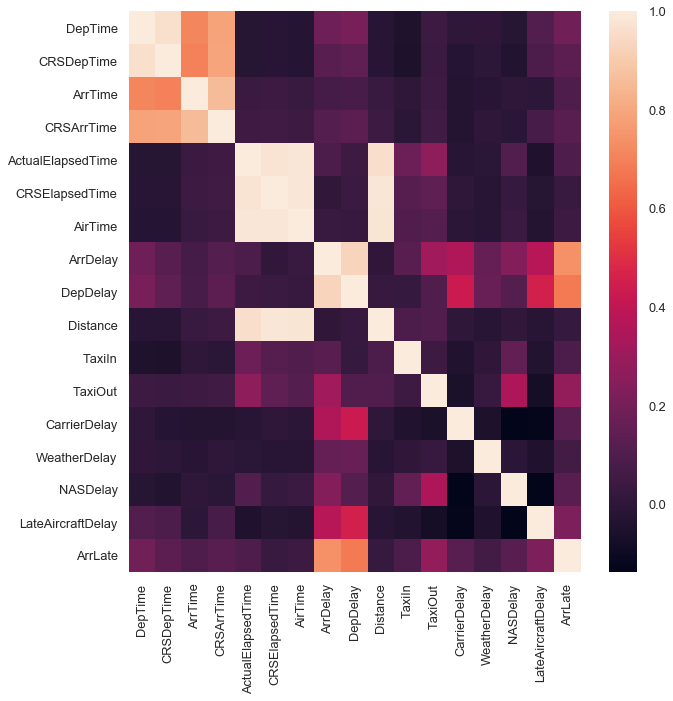

In [29]:
# By using correlation matrix we can start identifying factors that can help to predict lateness  
correlation_mat = df.corr()

#Plot heatmap
plt.figure(figsize=(10, 10))
ax = sns.heatmap(correlation_mat)  # use this if want text added to each box annot=True
plt.tight_layout()
plt.show()

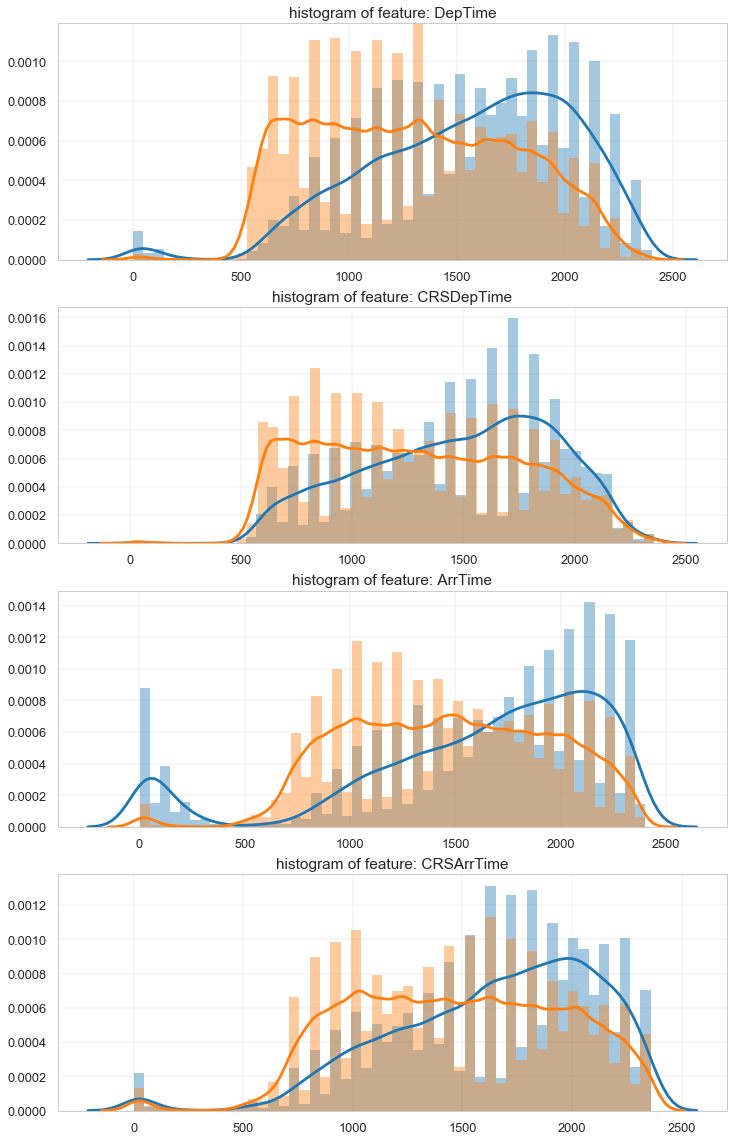

In [30]:
# let's draw the histogram for first four features:
current_palette = sns.color_palette()
import matplotlib.gridspec as gridspec
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(4, 1)
for i, cn in enumerate(df.columns[:4]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.ArrLate == 1], bins=50)
    sns.distplot(df[cn][df.ArrLate == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

# Above code will raise a warning related to deprecated function. And to avoid seeing this warning
# we suppress it using: 
warnings.simplefilter('ignore')

Histograms of the first four features show that delays are more frequent during later hours of the day. And when they happend they have chain affects on each other. This make sense as delays will have ripple effects on other schedules during of the day. 

## Dealing with class imbalance

Class imbalance can negatively influence both the evaluation of learning algorithms and also the learning process during the fitting stage. For machine learning algorithms we typically optimize a reward or cost function that is computed as a sum over the training examples that it sees during fitting. Because of this the decision rule is likely going to be biased towards the majority class.

One way to address this is to assign a larger penalty to wrong predictions on the minority class. Alternatively, we can include up-sampling the minority class, down-sampling the majority class or generate synthetic training samples. Unfortunately, there's no universally best solution, no technique that works best across different problem domains. In this case we will use the up-sampling of the late flights.

In [31]:
# Create a separate table for each class
df_minority = df[df.ArrLate == 1]
df_majority = df[df.ArrLate == 0]

# Determine the  size of minority class
minority_size = len(df[df['ArrLate'] == 1])
majority_size = len(df[df['ArrLate'] == 0])

# Upsample the minority case
minority_upsampled = resample(df_minority, replace=True, n_samples=majority_size, random_state=140)

# Combine in a new dataframe 'data' the majority class with the upsampled minority class
balanced_df = pd.concat([df_majority,minority_upsampled])
 
# Display new class counts
balanced_df.ArrLate.value_counts()

1    110572
0    110572
Name: ArrLate, dtype: int64

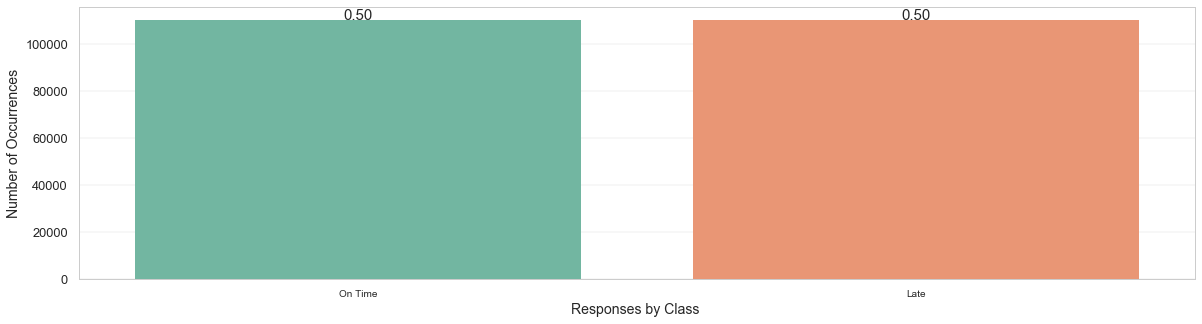

In [32]:
# To show any imbalance 
plt.figure(figsize=(20, 5))
sns.set_style("whitegrid")
plt.subplot(1, 1, 1)
ax = sns.countplot(x="ArrLate", data=balanced_df, palette="Set2")
ax.set_xlabel('Responses by Class ')
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(['On Time','Late'], fontsize=10)

# Use below function to calcualte the percentage for each bar
total = float(len(balanced_df)) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),fontsize=fontsize, ha="center") 
    
#plt.ylim(0, 50000) # Use this if want to show a subset of all data

In [33]:
# To save time and gain speed make a copy of previous df to new dataframe
df2 = balanced_df.copy()

In [34]:
df2.shape

(221144, 21)

In [35]:
# Identify selective column names for normanlization
# df3 used only for plotting purpose
df3 = df2[['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance',
        'CarrierDelay', 'WeatherDelay', 'LateAircraftDelay','ArrLate']]

In [36]:
df2.shape, df3.shape

((221144, 21), (221144, 10))

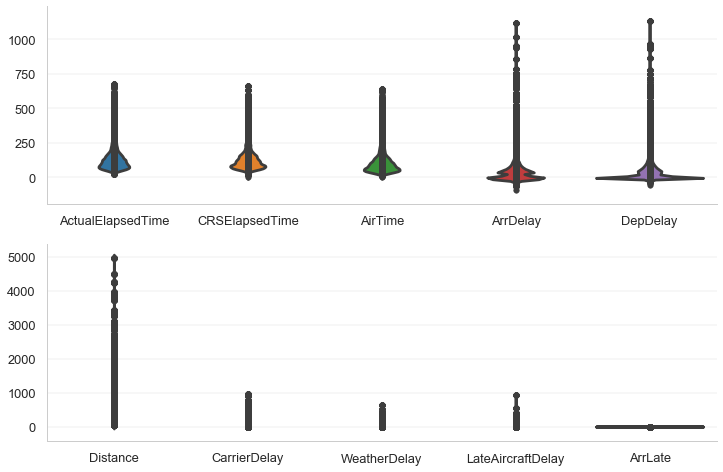

In [37]:
# Create a figure instance, and the two subplots to show if we have any problems with outliers
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Tell pointplot to plot on ax1 with the ax argument
sns.violinplot(data=df3.ix[:,0:5], inner="points", ax=ax1)    
sns.violinplot(data=df3.ix[:,5:10], inner="points", ax=ax2)
fig.set_size_inches(12, 8)
sns.despine()

In [38]:
# Filter away all outliers identified as those within +/-3 standard deviations in ArrDelay and DepDelay
# df3 is only for plotting purpose
df3 = df3[np.abs(df3.ArrDelay-df3.ArrDelay.mean()) <= (3*df3.ArrDelay.std())]
df3 = df3[np.abs(df3.DepDelay-df3.DepDelay.mean()) <= (3*df3.DepDelay.std())]

In [39]:
# Filter away all outliers identified as those within +/-3 standard deviations in ArrDelay and DepDelay
# df2 will be used for actual modeling later
df2 = df2[np.abs(df2.ArrDelay-df2.ArrDelay.mean()) <= (3*df2.ArrDelay.std())]
df2 = df2[np.abs(df2.DepDelay-df2.DepDelay.mean()) <= (3*df2.DepDelay.std())]

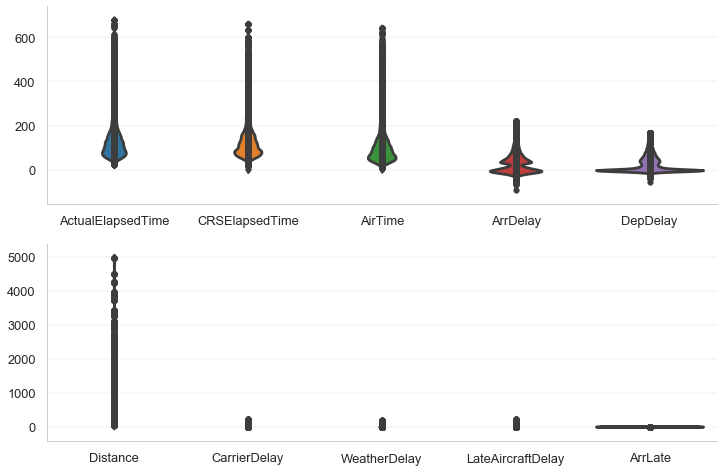

In [40]:
# Create a figure instance, and the two subplots and check the outliers 
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Tell pointplot to plot on ax1 with the ax argument
sns.violinplot(data=df3.ix[:,0:5], inner="points", ax=ax1)    
sns.violinplot(data=df3.ix[:,5:10], inner="points", ax=ax2)
fig.set_size_inches(12, 8)
sns.despine()

In [41]:
# Extract selective columns for normanlization
df_for_norm = df2[['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay',
                   'Distance','CarrierDelay', 'WeatherDelay', 'LateAircraftDelay']]
df_class = df2[['ArrLate']]

df_rem = df2.drop(['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay',
                   'Distance','CarrierDelay', 'WeatherDelay', 'LateAircraftDelay', 'ArrLate'], axis=1)

df_for_norm = df_for_norm.reset_index(drop=True)
df_class = df_class.reset_index(drop=True)
df_rem = df_rem.reset_index(drop=True)

In [42]:
df2.shape, df_for_norm.shape, df_class.shape, df_rem.shape

((213349, 21), (213349, 9), (213349, 1), (213349, 11))

Based on above we should remove outliers from ArrDelay and DepDelay features. 

In [43]:
# Inspect the headings of these dataframes
df_for_norm.head(3)

,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,LateAircraftDelay
0,60.0,55.0,39.0,1.0,-4.0,162.0,15.986164,2.909958,21.028685
1,165.0,190.0,155.0,4.0,29.0,1093.0,15.986164,2.909958,21.028685
2,47.0,55.0,35.0,-8.0,0.0,197.0,15.986164,2.909958,21.028685


In [44]:
df_rem.head(3)

,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,Origin,Dest,TaxiIn,TaxiOut,NASDelay
0,1426.0,1430.0,1426.0,1425.0,WN,N476WN,IND,MDW,9.0,12.0,16.959259
1,1954.0,1925.0,2239.0,2235.0,WN,N243WN,ISP,FLL,3.0,7.0,16.959259
2,655.0,655.0,742.0,750.0,WN,N244WN,LAS,ONT,4.0,8.0,16.959259


In [45]:
df_class.head(3)

,ArrLate
0,0
1,0
2,0


In [46]:
# Normalize selective columns

col_name = df_for_norm.columns # Keep a copy of column names
min_max_scaler = preprocessing.MinMaxScaler() # Create a minimum and maximum processor object

# Create an object to transform the data to fit minmax processor
df_scaled = min_max_scaler.fit_transform(df_for_norm)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(df_scaled)

df_normalized.columns = [col_name] # Add back column names 

In [47]:
# Inspect the data type
df_normalized.dtypes.index

MultiIndex(levels=[['ActualElapsedTime', 'AirTime', 'ArrDelay', 'CRSElapsedTime', 'CarrierDelay', 'DepDelay', 'Distance', 'LateAircraftDelay', 'WeatherDelay']],
           labels=[[0, 3, 1, 2, 5, 6, 4, 8, 7]])

In [48]:
# Need to flatten the level of this dataframe
df_normalized.columns = df_normalized.columns.get_level_values(0)

In [49]:
# Check the column headings
df_normalized.head(2), df_normalized.shape

(   ActualElapsedTime  CRSElapsedTime   AirTime  ArrDelay  DepDelay  Distance  \
 0           0.056402        0.081942  0.057813  0.291667  0.228700  0.024588   
 1           0.216463        0.286798  0.239063  0.301282  0.376682  0.213778   
 
    CarrierDelay  WeatherDelay  LateAircraftDelay  
 0      0.074354      0.015815           0.096021  
 1      0.074354      0.015815           0.096021  , (213349, 9))

In [50]:
# Inspect the table
df_rem.head(2), df_rem.shape

(   DepTime  CRSDepTime  ArrTime  CRSArrTime UniqueCarrier TailNum Origin Dest  \
 0   1426.0      1430.0   1426.0      1425.0            WN  N476WN    IND  MDW   
 1   1954.0      1925.0   2239.0      2235.0            WN  N243WN    ISP  FLL   
 
    TaxiIn  TaxiOut   NASDelay  
 0     9.0     12.0  16.959259  
 1     3.0      7.0  16.959259  , (213349, 11))

In [51]:
# After normalization we combine the tables into one 
features_only = pd.merge(df_normalized, df_rem, right_index=True, left_index=True)

In [52]:
# Check it again
features_only.head(2), features_only.shape

(   ActualElapsedTime  CRSElapsedTime   AirTime  ArrDelay  DepDelay  Distance  \
 0           0.056402        0.081942  0.057813  0.291667  0.228700  0.024588   
 1           0.216463        0.286798  0.239063  0.301282  0.376682  0.213778   
 
    CarrierDelay  WeatherDelay  LateAircraftDelay  DepTime  CRSDepTime  \
 0      0.074354      0.015815           0.096021   1426.0      1430.0   
 1      0.074354      0.015815           0.096021   1954.0      1925.0   
 
    ArrTime  CRSArrTime UniqueCarrier TailNum Origin Dest  TaxiIn  TaxiOut  \
 0   1426.0      1425.0            WN  N476WN    IND  MDW     9.0     12.0   
 1   2239.0      2235.0            WN  N243WN    ISP  FLL     3.0      7.0   
 
     NASDelay  
 0  16.959259  
 1  16.959259  , (213349, 20))

In [53]:
# Describe the data using statistics
features_only.describe()

,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,LateAircraftDelay,DepTime,CRSDepTime,ArrTime,CRSArrTime,TaxiIn,TaxiOut,NASDelay
count,213349.000000,213349.000000,213349.000000,213349.000000,213349.000000,213349.000000,213349.000000,213349.000000,213349.000000,213349.000000,213349.000000,213349.000000,213349.000000,213349.000000,213349.000000,213349.000000
mean,0.169288,0.197708,0.164760,0.387897,0.373830,0.142772,0.074879,0.015447,0.105206,1423.454496,1386.299425,1540.537092,1555.768876,7.263703,19.346736,18.081403
std,0.111795,0.107013,0.107908,0.140393,0.179698,0.115409,0.097931,0.054336,0.113603,475.657848,452.729514,537.983379,479.596795,6.225929,16.024041,22.067968
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.086890,0.119879,0.085938,0.272436,0.237668,0.059338,0.000000,0.000000,0.000000,1036.000000,1015.000000,1158.000000,1205.000000,4.000000,10.000000,4.000000
50%,0.141768,0.169954,0.135938,0.362179,0.291480,0.111563,0.074354,0.015815,0.096021,1440.000000,1415.000000,1615.000000,1612.000000,6.000000,15.000000,16.959259
75%,0.217988,0.241275,0.209375,0.461538,0.470852,0.189189,0.074354,0.015815,0.096021,1822.000000,1750.000000,1957.000000,1940.000000,8.000000,22.000000,16.959259
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2400.000000,2359.000000,2400.000000,2359.000000,148.000000,253.000000,222.000000


In [54]:
# Create binary labels for the categorial data
features_only = pd.get_dummies(features_only,columns=['UniqueCarrier'], drop_first=True)
features_only = pd.get_dummies(features_only,columns=['Origin'], drop_first=True)
features_only = pd.get_dummies(features_only,columns=['Dest'], drop_first=True)
features_only = pd.get_dummies(features_only,columns=['TailNum'], drop_first=True)

In [55]:
# Inspect again
features_only.head(2), features_only.shape # Check the result

(   ActualElapsedTime  CRSElapsedTime   AirTime  ArrDelay  DepDelay  Distance  \
 0           0.056402        0.081942  0.057813  0.291667  0.228700  0.024588   
 1           0.216463        0.286798  0.239063  0.301282  0.376682  0.213778   
 
    CarrierDelay  WeatherDelay  LateAircraftDelay  DepTime       ...        \
 0      0.074354      0.015815           0.096021   1426.0       ...         
 1      0.074354      0.015815           0.096021   1954.0       ...         
 
    TailNum_N994DL  TailNum_N995AT  TailNum_N995DL  TailNum_N996AT  \
 0               0               0               0               0   
 1               0               0               0               0   
 
    TailNum_N996DL  TailNum_N997AT  TailNum_N997DL  TailNum_N998AT  \
 0               0               0               0               0   
 1               0               0               0               0   
 
    TailNum_N998DL  TailNum_N999DN  
 0               0               0  
 1               0   

## Principla Component Analysis

In [56]:
# We have hundres of features and next we will use principal component analysis (PCA) 
# to reduce the number of features. 
# By using PCA we can rank most important features capable of explaining the total variance by the data.
# With PCA we can determine which features capture similiar information and discard them to create a more lean model.

In [57]:
# Principal component
n_components = 3
covar_matrix = PCA(n_components = n_components) # Selecting n_components PCA factors
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(features_only)
X_pca = pd.DataFrame(X_pca, columns=['PC-1', 'PC-2','PC-3']) 

covar_matrix.fit(features_only)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios
var2 = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100) # Calcualte the cumulative variance
var2

array([78.2, 93.8, 98.8])

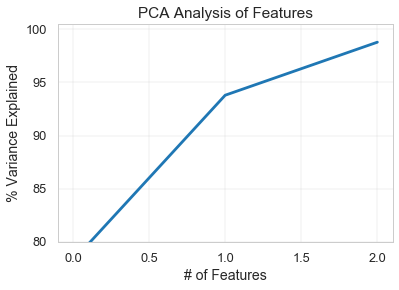

In [58]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis of Features')
plt.ylim(80,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var2) # Showing the cumulative contributions of PCAs

In [59]:
df_pca = pd.DataFrame(pca.components_,columns=features_only.columns,index = ['PC-1', 'PC-2','PC-3'])
df_pca.ix[:, df_pca.max().sort_values(ascending=False).index]

,CRSDepTime,DepTime,ArrTime,NASDelay,DepDelay,TaxiIn,Dest_ORD,UniqueCarrier_OO,UniqueCarrier_MQ,LateAircraftDelay,...,Origin_SLC,Dest_ISP,Dest_LGA,CRSElapsedTime,Dest_EWR,Origin_DEN,Origin_PHL,Origin_MCO,TaxiOut,CRSArrTime
PC-1,-0.475471,-0.507015,-0.504511,0.000577,-0.000051,0.000060,0.000012,9.372055e-06,0.000008,-0.000020,...,-9.307832e-07,-9.395015e-07,-0.000001,-0.000001,-0.000002,-0.000006,-0.000002,-0.000002,-0.000773,-0.512183
PC-2,0.431221,0.414573,-0.801054,-0.004381,0.000063,-0.000885,-0.000020,9.591111e-07,-0.000006,0.000038,...,-4.210658e-06,-9.314508e-07,-0.000010,-0.000012,-0.000001,-0.000002,-0.000003,-0.000002,-0.001077,-0.021651
PC-3,0.269758,0.294906,0.321051,-0.000366,0.000048,-0.000613,0.000041,4.073638e-05,0.000040,0.000005,...,-2.201337e-06,-1.733524e-06,-0.000017,-0.000060,-0.000016,-0.000009,-0.000004,-0.000007,-0.002089,-0.858593


### Above shows that ArrTime and CRSDepTime and DepTim are the features with most contributions to PCAs

In [69]:
X_pca.shape, df_class.shape# Check the dimensions

((213349, 3), (213349, 1))

### Model Selection ###

We split the dataset 80/20 between train and test parts. We will train and fit multiple models using the training set and do evaluation of their predictive power using the test data. Splitting the dateset is the critical strategy for reducing the risk of overfitting.

We also tune the hyperparameters of all models to improve their prediction powers. And confusion matrix to demonstrate characteristics such as accuracy, sensitivity/recall, specificity, false positive rate and precision.

As the purpose of the analysis is to predict lateness we will focus on accuracy as the main evaluation metric. 

We tested following models:

  - Decision Tree
  - Random Forest
  - Logistic Regression
  - Naive - Bayes (Bernoulli)
  - KNeighbors Classifier
  - Support Vector Machine
  - Gradient Boosting Classifier

### Training and testing set preparation
Priot to model selection we need to split the data into training, development and test set. We are using first 80% of the data as the training and validation set. The remaining 20% will be used as the testing set:

In [61]:
test_size = 0.2 # Test size

# Create training and test set
train_x, test_x, train_y, test_y = train_test_split(X_pca, 
    df_class, test_size = test_size, random_state = 42)

# Convert to numpy array
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

# Reshape lables dataset from (R,1) to (R,) 
c, r = train_y.shape
c1, r1 = test_y.shape
train_y = train_y.reshape(c,)
test_y = test_y.reshape(c1,)

# Number of cross validation used for all models
CF_no = 5

In [62]:
# Check the shapes
train_x.shape, test_x.shape, train_y.shape, test_y.shape 

((170679, 3), (42670, 3), (170679,), (42670,))

In [63]:
# Check the types
type(train_x), type(test_x), type(train_y), type(test_y)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [64]:
total_size = X_pca.shape
train_x_size = train_x.shape
train_y_size = train_y.shape
test_x_size = test_x.shape
test_y_size = test_y.shape

print("Size of total sample: {}. ".format(total_size)) 
print("Size of training x: {}. ".format(train_x_size)) 
print("Sizae of training y: {}. ".format(train_y_size))
print("Size of test x: {}. ".format(test_x_size)) 
print("Size of test y: {}. ".format(test_y_size))

Size of total sample: (213349, 3). 
Size of training x: (170679, 3). 
Sizae of training y: (170679,). 
Size of test x: (42670, 3). 
Size of test y: (42670,). 


Some algorithms are very computationally expensive and for those we use much smaller sample size. Below we are extracting a smaller set of samples from training and test data set.

In [65]:
# Size of smaller samples
total_small_sample_size = min(s_small,s)
train_small_sample_size = total_small_sample_size * (1-test_size)
test_small_sample_size = total_small_sample_size * test_size


# For train data
idx1 = np.random.choice(np.arange(len(train_x)), int(train_small_sample_size), replace=False)
train_x_small = train_x[idx1]
train_y_small = train_y[idx1]

# For test data
idx2 = np.random.choice(np.arange(len(test_x)), int(test_small_sample_size), replace=False)
test_x_small = test_x[idx2]
test_y_small = test_y[idx2]

In [66]:
# Inspect to see the smaller sample size make sense
total_size = X_pca.shape
train_x_size = train_x_small.shape
train_y_size = train_y_small.shape
test_x_size = test_x_small.shape
test_y_size = test_y_small.shape

print("Size of total sample: {}. ".format(total_size))
print("Size of training x: {}. ".format(train_x_size)) 
print("Sizae of training y: {}. ".format(train_y_size))
print("Size of test x: {}. ".format(test_x_size)) 
print("Size of test y: {}. ".format(test_y_size))

Size of total sample: (213349, 3). 
Size of training x: (4000, 3). 
Sizae of training y: (4000,). 
Size of test x: (1000, 3). 
Size of test y: (1000,). 


In [67]:
# Test to see if smaller samples match exactly with their source
print((train_x_small==[train_x[i] for i in (idx1)]).all()) # Fro train data
print((train_y_small==[train_y[i] for i in (idx1)]).all()) # Fro train data
print((test_x_small==[test_x[i] for i in (idx2)]).all()) # Fro test data
print((test_y_small==[test_y[i] for i in (idx2)]).all()) # Fro train data

True
True
True
True


### Visualizing the performance of each model

For each model we are going to take a look at visualizing the confusion matrix. And based on these we will extract the performance results. A confusion matrix helps to understand the performance of a classification model. This again helps to 
fine tune the algorithm, by understanding how the data gets misclassified.

Below we build a  function to create confusion matrix consisting of two parts: Part one is used for all all models and part two depends on modelspecific data.

In [68]:
# First part of Confusion matrix function

import itertools  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confustion_m_labels = ['l1','l2']

In [74]:
# Prepare a global dictionary for labels
y_label_dict = {"y_label1":'On Time', "y_label2":'Late'} 
y_label1 = y_label_dict[list(y_label_dict)[0]] # y_label1
y_label2 = y_label_dict[list(y_label_dict)[1]] # y_label2

## Model Training: Decision Tree

In [380]:
# Start a simple decision tree with default values as a base model

CF_no = 10 # Crossfold validation
D_tree = DecisionTreeClassifier(random_state=42)
scores = sklearn.cross_validation.cross_val_score(D_tree, train_x, train_y, cv=CF_no)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.99 (+/- 0.00)


In [381]:
print('Parameters currently in use:\n')
print(D_tree.get_params())

Parameters currently in use:

{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 42, 'splitter': 'best'}


To see if we can improve the score we will try adjusting the model's parameters. 

In [382]:
# set of parameters to test
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

D_tree = DecisionTreeClassifier()

D_tree_gs=GridSearchCV(D_tree, param_grid=param_grid, cv=CF_no)
D_tree_gs.fit(train_x, train_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 10, 20], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10], 'max_leaf_nodes': [None, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [383]:
# Get the parameters giving the highest score
D_tree_gs.grid_scores_[0]

mean: 0.99125, std: 0.00080, params: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [384]:
# Rerun the calssifier using parameters with highest scores
D_tree_gs = DecisionTreeClassifier(random_state=42, min_samples_leaf= 1, max_depth= None, criterion = 'gini')
scores = sklearn.cross_validation.cross_val_score(D_tree_gs, train_x, train_y, cv=CF_no)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.99 (+/- 0.00)


In [385]:
# To visualize the tree we will reduce the max_depth
D_tree_gs = DecisionTreeClassifier(random_state=42, min_samples_leaf= 1, max_depth= 3, criterion = 'gini')
D_tree_gs.fit(train_x, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

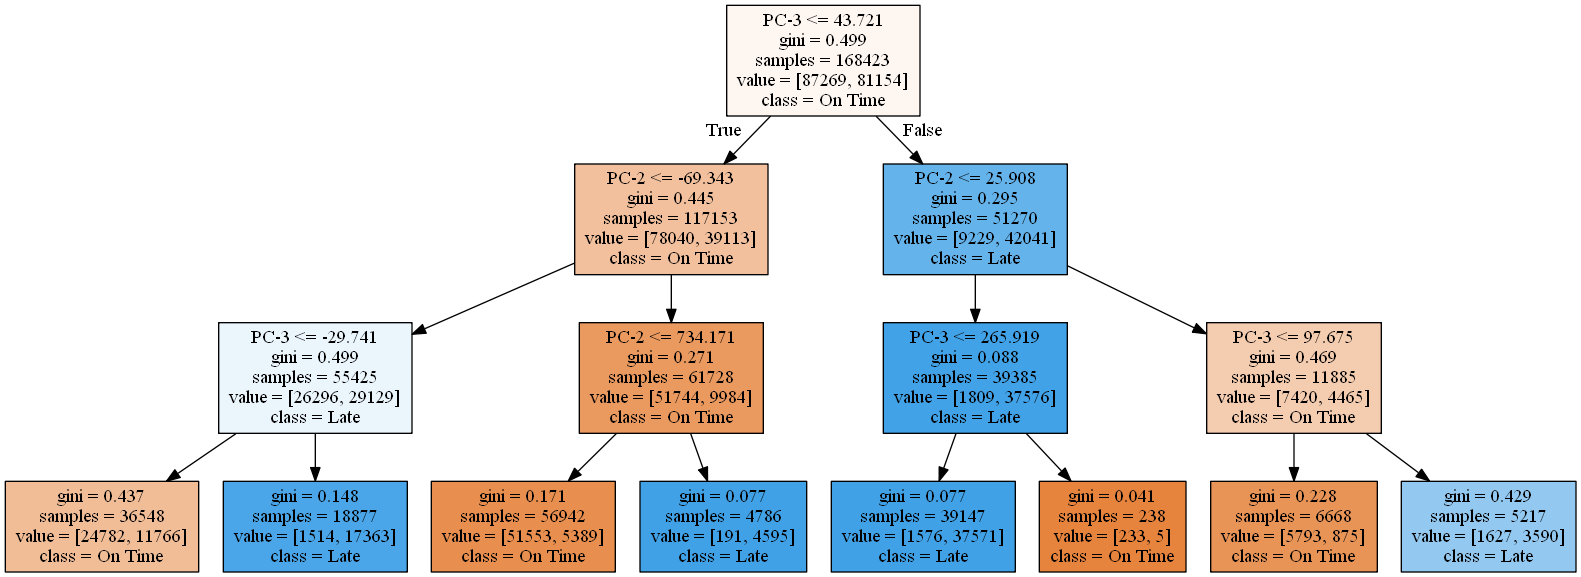

In [386]:
names = X_pca.iloc[:, :].columns # Names of X features 

# Render the decision tree
dot_data = tree.export_graphviz(D_tree_gs, out_file=None, feature_names = names, 
    class_names = ['On Time', 'Late'],
    filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [387]:
# To check the prediction power of the model we need to put back the best parameters and fit the model
D_tree_gs = DecisionTreeClassifier(random_state=42, min_samples_leaf= 1, max_depth= None, criterion = 'gini')
D_tree_gs.fit(train_x, train_y)
pred_y = np.array(D_tree_gs.predict(test_x))
true_y = np.array(test_y)

Confusion matrix, without normalization
[[21348   358]
 [    8 20392]]


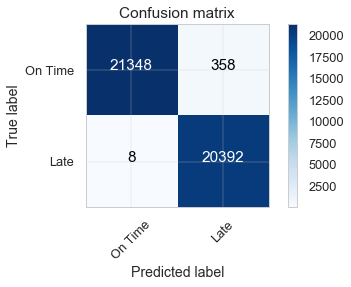

In [388]:
# The second part of Confusion matrix which depends on each model
class_names = [y_label1, y_label2]
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [389]:
target_names = [y_label1, y_label2]
print(classification_report(true_y, pred_y, target_names=target_names))

             precision    recall  f1-score   support

    On Time       1.00      0.98      0.99     21706
       Late       0.98      1.00      0.99     20400

avg / total       0.99      0.99      0.99     42106



In [390]:
TN, FP, FN, TP = cnf_matrix.ravel() # Getting all results from the matrix and calcualte all KPIs
accuracy = (TP + TN) / (TP + TN + FP + FN)
miss_calc_rate = (FP + FN) / (TP + TN + FP + FN)
true_pos_rate = TP / (FN + TP)
false_pos_rate = FP / (TN + FP)
specificity = TN / (TN+FP)
precision = TP/(FP+TP)
prevalence = (FN+TP)/(TP + TN + FP + FN)
class_names = [y_label1, y_label2]

print("True Positives (TP): Correctly predicted %s for %s" % (format(y_label2), TP))
print("True Negatives (TN): Correctly predicted %s for %s" % (format(y_label1), TN))
print("False Positives (FP): Incorrectly predicted that it is %s or Type I error: %s" %(format(y_label2), FP))
print("False Negatives (FN): Incorrectly predicted that it is %s or Type II error: %s" %(format(y_label1), FN))
print("=============================")
print("Overall, how often is the classifier correct or Accuracy? %s" %format(accuracy,'.2f')) 
print("Overall, how often is the classifier incorrect or Misclassification Rate? %s" %format(miss_calc_rate,'.2f')) 
print("When the actual value is positive, how often is the prediction correct \
(Sensitivity or Recall)? %s" %(format(true_pos_rate,'.2f')))
print("When the actual value is negative, how often is the prediction correct \
(Specificity)? %s" %format(specificity,'.2f'))
print("When the actual value is negative, how often is the prediction incorrect \
(False Positive Rate)? %s" %format(false_pos_rate,'.2f'))
print("When a positive value is predicted, how often is the prediction correct \
(Precision)? %s" %format(precision,'.2f'))
print("How often does the yes condition actually occur in our sample (Prevalence)? %s" %format(prevalence,'.2f'))

True Positives (TP): Correctly predicted Late for 20392
True Negatives (TN): Correctly predicted On Time for 21348
False Positives (FP): Incorrectly predicted that it is Late or Type I error: 358
False Negatives (FN): Incorrectly predicted that it is On Time or Type II error: 8
Overall, how often is the classifier correct or Accuracy? 0.99
Overall, how often is the classifier incorrect or Misclassification Rate? 0.01
When the actual value is positive, how often is the prediction correct (Sensitivity or Recall)? 1.00
When the actual value is negative, how often is the prediction correct (Specificity)? 0.98
When the actual value is negative, how often is the prediction incorrect (False Positive Rate)? 0.02
When a positive value is predicted, how often is the prediction correct (Precision)? 0.98
How often does the yes condition actually occur in our sample (Prevalence)? 0.48


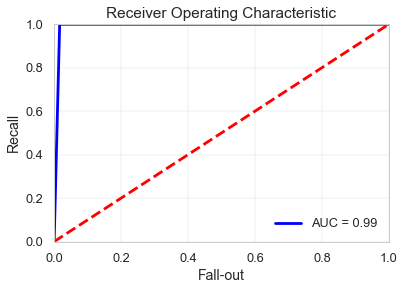

In [391]:
# The dashed line in the following figure is for a classifier that predicts 
# classes randomly; it has an AUC of 0.5. The solid curve is for a classifier 
# that outperforms random guessing:

false_positive_rate, recall, thresholds = roc_curve(test_y, pred_y)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

## Model Training: Random Forest

In [392]:
# Run the default Random Forest and examine the default values
rf = RandomForestClassifier()

# Current parameters used
print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [393]:
# One way tunining the parameters here is to use RandomizedSearchCV
# But before that we should create a parameter grid to sample from

# Number of trees 
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 20)]
# Number of features at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels
max_depth = [int(x) for x in np.linspace(3, 15, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rand_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(rand_grid)

{'n_estimators': [10, 35, 61, 87, 113, 138, 164, 190, 216, 242, 267, 293, 319, 345, 371, 396, 422, 448, 474, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 6, 9, 12, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 10], 'bootstrap': [True, False]}


In [394]:
rf_rand = RandomizedSearchCV(estimator = rf, param_distributions = rand_grid, n_iter = 100, cv = CF_no, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_rand.fit(train_x, train_y)

# The most important argument in RandomizedSearchCV are 
# n_iter: Number of different combinations to try
# cv:  Number of folds to use for cross validation

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 55.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 109.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 187.3min finished


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 35, 61, 87, 113, 138, 164, 190, 216, 242, 267, 293, 319, 345, 371, 396, 422, 448, 474, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 6, 9, 12, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 10], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          scoring=None, verbose=2)

In [395]:
# Get the best parameters and use them to narrow down the range of values for each parameter
rf_rand.best_params_

{'n_estimators': 345,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

We should compare the previous best parameters from random search with the ones from base model to make sure we have picked the right combinations.

In [396]:
# Create an evaluation function

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean((np.divide(errors, test_y, where=test_y!=0)))
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

In [397]:
# Run the base model
base_model = RandomForestClassifier(random_state = 42)
base_model.fit(train_x, train_y)
base_accuracy = evaluate(base_model, test_x, test_y)

Model Performance
Average Error: 0.0057 degrees.
Accuracy = 99.97%.


In [398]:
# Evaluate the base model with the one with randomly sampled parameters
best_random = rf_rand.best_estimator_
random_accuracy = evaluate(best_random, test_x, test_y)

Model Performance
Average Error: 0.0043 degrees.
Accuracy = 99.97%.


In [399]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.00%.


By using the results from random sampling we can now reduce the range for each hyperparameter. We can now explicitly specify every combination of settings to try. GridSearchCV is the method for this workflow.

In [400]:
# Use the results from random search and define a narrower range to focus on
param_grid = {
    'bootstrap': [True],
    'max_depth': [10,15 ,20, 30],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 4],
    'n_estimators': [250, 293, 400]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = CF_no, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(train_x, train_y)
grid_search.best_params_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 92.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 173.9min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 198.5min finished


{'bootstrap': True,
 'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [401]:
# Instantiate model 
rf = RandomForestClassifier(bootstrap=True, max_depth=20,
                            min_samples_leaf=1, min_samples_split=2,
                            n_estimators=250, random_state=42)

rf.fit(train_x, train_y); # Train the model on training data
predictions = rf.predict(test_x) # Use the Forest's predict method on the test data
errors = abs(predictions - test_y) # Calculate the absolute errors
# Print out the mean absolute error (mae)
print('Average model error:', round(np.mean(errors), 2), 'degrees.')

Average model error: 0.01 degrees.


In [402]:
# Check the prediction power of the model
threshold = 0.5  # This to round the numbers as binary 0 or 1
pred_y = np.array(grid_search.predict(test_x)>threshold).astype(int)
true_y = np.array(test_y)

Confusion matrix, without normalization
[[21477   229]
 [   11 20389]]


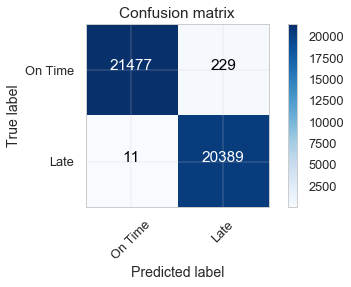

In [403]:
# The second part of Confusion matrix which depends on each model
class_names = [y_label1, y_label2]
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [404]:
target_names = [y_label1, y_label2]
print(classification_report(true_y, pred_y, target_names=target_names))

             precision    recall  f1-score   support

    On Time       1.00      0.99      0.99     21706
       Late       0.99      1.00      0.99     20400

avg / total       0.99      0.99      0.99     42106



In [405]:
TN, FP, FN, TP = cnf_matrix.ravel() # Getting all results from the matrix and calcualte all KPIs
accuracy = (TP + TN) / (TP + TN + FP + FN)
miss_calc_rate = (FP + FN) / (TP + TN + FP + FN)
true_pos_rate = TP / (FN + TP)
false_pos_rate = FP / (TN + FP)
specificity = TN / (TN+FP)
precision = TP/(FP+TP)
prevalence = (FN+TP)/(TP + TN + FP + FN)
class_names = [y_label1, y_label2]

print("True Positives (TP): Correctly predicted %s for %s" % (format(y_label2), TP))
print("True Negatives (TN): Correctly predicted %s for %s" % (format(y_label1), TN))
print("False Positives (FP): Incorrectly predicted that it is %s or Type I error: %s" %(format(y_label2), FP))
print("False Negatives (FN): Incorrectly predicted that it is %s or Type II error: %s" %(format(y_label1), FN))
print("=============================")
print("Overall, how often is the classifier correct or Accuracy? %s" %format(accuracy,'.2f')) 
print("Overall, how often is the classifier incorrect or Misclassification Rate? %s" %format(miss_calc_rate,'.2f')) 
print("When the actual value is positive, how often is the prediction correct \
(Sensitivity or Recall)? %s" %(format(true_pos_rate,'.2f')))
print("When the actual value is negative, how often is the prediction correct \
(Specificity)? %s" %format(specificity,'.2f'))
print("When the actual value is negative, how often is the prediction incorrect \
(False Positive Rate)? %s" %format(false_pos_rate,'.2f'))
print("When a positive value is predicted, how often is the prediction correct \
(Precision)? %s" %format(precision,'.2f'))
print("How often does the yes condition actually occur in our sample (Prevalence)? %s" %format(prevalence,'.2f'))

True Positives (TP): Correctly predicted Late for 20389
True Negatives (TN): Correctly predicted On Time for 21477
False Positives (FP): Incorrectly predicted that it is Late or Type I error: 229
False Negatives (FN): Incorrectly predicted that it is On Time or Type II error: 11
Overall, how often is the classifier correct or Accuracy? 0.99
Overall, how often is the classifier incorrect or Misclassification Rate? 0.01
When the actual value is positive, how often is the prediction correct (Sensitivity or Recall)? 1.00
When the actual value is negative, how often is the prediction correct (Specificity)? 0.99
When the actual value is negative, how often is the prediction incorrect (False Positive Rate)? 0.01
When a positive value is predicted, how often is the prediction correct (Precision)? 0.99
How often does the yes condition actually occur in our sample (Prevalence)? 0.48


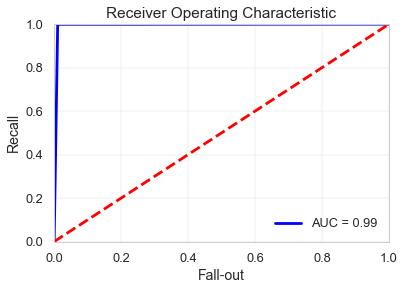

In [406]:
# The dashed line in the following figure is for a classifier that predicts 
# classes randomly; it has an AUC of 0.5. The solid curve is for a classifier 
# that outperforms random guessing:

false_positive_rate, recall, thresholds = roc_curve(test_y, pred_y)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

## Model Training: Logistic Regression

In [407]:
#Start the timer as a measure of the computing effort
start_time = time.time()

# Check any overfitting problem using Cross Fold validation
log_reg = sklearn.linear_model.LogisticRegression()
score = sklearn.cross_validation.cross_val_score(log_reg, train_x, train_y, cv=5)
print(score)

[0.61 0.61 0.61 0.61 0.61]


In [408]:
#Tune parameters
c_param = [0.1,1, 10] # C parameter

#Tune the type of penalty used between l1 and l2
penalty_type = ['l1','l2']
parameters = {'C': c_param, 'penalty': penalty_type}

#Fit parameters
%timeit  
log_reg_tuned = GridSearchCV(log_reg, param_grid=parameters, cv=CF_no)

#Fit the tunned classifier in the traiing space
log_reg_tuned.fit(train_x, train_y)

#Print the best parameters
print(log_reg_tuned.best_params_)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

{'C': 0.1, 'penalty': 'l2'}
--- 17 seconds ---


In [409]:
# Check the prediction power of the model
pred_y = np.array(log_reg_tuned.predict(test_x))
true_y = np.array(test_y)

### Evaluating the model
Below we will use the confusion matrix which is a way of tabulating the number of misclassifications. Also, we can see the number of predicted classes which were categorized wrongly as true. But before that we need to set up a function that also plots the outcome of this matrix.

Confusion matrix, without normalization
[[13815  7891]
 [ 8666 11734]]


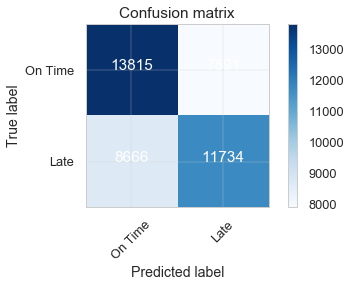

In [410]:
# The second part of Confusion matrix which depends on each model
class_names = [y_label1, y_label2]
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [411]:
target_names = class_names
print(classification_report(true_y, pred_y, target_names=target_names))

             precision    recall  f1-score   support

    On Time       0.61      0.64      0.63     21706
       Late       0.60      0.58      0.59     20400

avg / total       0.61      0.61      0.61     42106



In [412]:
TN, FP, FN, TP = cnf_matrix.ravel() # Getting all results from the matrix and calcualte all KPIs
accuracy = (TP + TN) / (TP + TN + FP + FN)
miss_calc_rate = (FP + FN) / (TP + TN + FP + FN)
true_pos_rate = TP / (FN + TP)
false_pos_rate = FP / (TN + FP)
specificity = TN / (TN+FP)
precision = TP/(FP+TP)
prevalence = (FN+TP)/(TP + TN + FP + FN)
class_names = [y_label1, y_label2]

print("True Positives (TP): Correctly predicted %s for %s" % (format(y_label2), TP))
print("True Negatives (TN): Correctly predicted %s for %s" % (format(y_label1), TN))
print("False Positives (FP): Incorrectly predicted that it is %s or Type I error: %s" %(format(y_label2), FP))
print("False Negatives (FN): Incorrectly predicted that it is %s or Type II error: %s" %(format(y_label1), FN))
print("=============================")
print("Overall, how often is the classifier correct or Accuracy? %s" %format(accuracy,'.2f')) 
print("Overall, how often is the classifier incorrect or Misclassification Rate? %s" %format(miss_calc_rate,'.2f')) 
print("When the actual value is positive, how often is the prediction correct \
(Sensitivity or Recall)? %s" %(format(true_pos_rate,'.2f')))
print("When the actual value is negative, how often is the prediction correct \
(Specificity)? %s" %format(specificity,'.2f'))
print("When the actual value is negative, how often is the prediction incorrect \
(False Positive Rate)? %s" %format(false_pos_rate,'.2f'))
print("When a positive value is predicted, how often is the prediction correct \
(Precision)? %s" %format(precision,'.2f'))
print("How often does the yes condition actually occur in our sample (Prevalence)? %s" %format(prevalence,'.2f'))

True Positives (TP): Correctly predicted Late for 11734
True Negatives (TN): Correctly predicted On Time for 13815
False Positives (FP): Incorrectly predicted that it is Late or Type I error: 7891
False Negatives (FN): Incorrectly predicted that it is On Time or Type II error: 8666
Overall, how often is the classifier correct or Accuracy? 0.61
Overall, how often is the classifier incorrect or Misclassification Rate? 0.39
When the actual value is positive, how often is the prediction correct (Sensitivity or Recall)? 0.58
When the actual value is negative, how often is the prediction correct (Specificity)? 0.64
When the actual value is negative, how often is the prediction incorrect (False Positive Rate)? 0.36
When a positive value is predicted, how often is the prediction correct (Precision)? 0.60
How often does the yes condition actually occur in our sample (Prevalence)? 0.48


Next, we will try a different model to see if we can reduce this error.

## Model Training: Naive Bayes

In this classification exercise we are also interested in the associated probabilities. These probabilities give us a some kind of confidence on the prediction. However, not all classifiers provide well-calibrated probabilities, some being over-confident while others being under-confident. Thus, a separate calibration of predicted probabilities is often desirable as a postprocessing. Below we use different calibration methods to evaluate the quality of the returned probabilities using Brier’s score.

In [413]:
# Use the Brier score which measures the accuracy of probabilistic predictions. 
# It is applicable to tasks in which predictions must assign probabilities to a set of mutually 
# exclusive discrete outcomes.”
# This function returns a score of the mean square difference between 
# the actual outcome and the predicted probability of the possible outcome. 
# The actual outcome has to be 1 or 0 (true or false), while the predicted probability of the actual 
# outcome can be a value between 0 and 1.

# The brier score loss is also between 0 to 1 and the lower the score (the mean square difference is smaller), 
# the more accurate the prediction is. 
# It can be thought of as a measure of the “calibration” of a set of probabilistic predictions.

#Start the timer as a measure of the computing effort
start_time = time.time()

# Gaussian Naive-Bayes with no calibration
clf = GaussianNB()
clf.fit(train_x, train_y)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(test_x)[:, 1]

# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=CF_no, method='isotonic')
clf_isotonic.fit(train_x, train_y) #, sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(test_x)[:, 1]

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=CF_no, method='sigmoid')
clf_sigmoid.fit(train_x, train_y) #, sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(test_x)[:, 1]

print("Brier scores: (the smaller the better)")

clf_score = brier_score_loss(test_y, prob_pos_clf) # , sw_test)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(test_y, prob_pos_isotonic) # , sw_test)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(test_y, prob_pos_sigmoid) # , sw_test)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)


#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

Brier scores: (the smaller the better)
No calibration: 0.265
With isotonic calibration: 0.227
With sigmoid calibration: 0.233
--- 1 seconds ---


Based on Brier scores isotoic calibration is working best. 

In [414]:
# We see isotonic calibration is performing best and below we run model evaluation on this version of Naive Bayes
y_pred_test = clf_sigmoid.predict(test_x)

#Print the time required to fit and evaluate the model
start_time = time.time()
print("Computational efforts: %s seconds ---" % (time.time() - start_time))

clf_isotonic_accuracy = accuracy_score(y_pred=y_pred_test, y_true=test_y)
clf_isotonic_precision = precision_score(y_pred=y_pred_test, y_true=test_y)
clf_isotonic_recall = recall_score(y_pred=y_pred_test, y_true=test_y)

print("Accuracy: {}. ".format(clf_isotonic_accuracy))
print("Precision: {}. ".format(clf_isotonic_precision))
print("Recall: {}. ".format(clf_isotonic_recall))

Computational efforts: 0.0 seconds ---
Accuracy: 0.6256590509666081. 
Precision: 0.6360596104200892. 
Recall: 0.5314215686274509. 


Confusion matrix, without normalization
[[13815  7891]
 [ 8666 11734]]


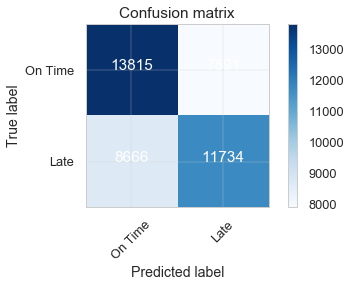

In [415]:
# The second part of Confusion matrix which depends on each model
class_names = [y_label1, y_label2]
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

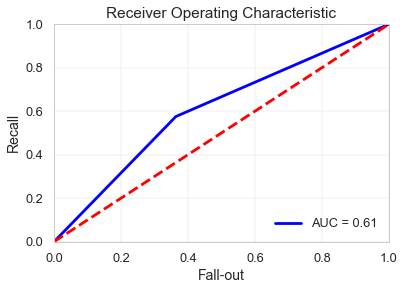

In [416]:
# The dashed line in the following figure is for a classifier that predicts 
# classes randomly; it has an AUC of 0.5. The solid curve is for a classifier 
# that outperforms random guessing:

false_positive_rate, recall, thresholds = roc_curve(test_y, pred_y)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

## Model Training: KNeighbors 

In [417]:
# from sklearn import preprocessing, model_selection, neighbors
# from sklearn.metrics import confusion_matrix, average_precision_score

#Start the timer as a measure of the computing effort
start_time = time.time()

KNN = KNeighborsClassifier()  #initialize the KNN classifier

# Create range of values to fit parameters
neighbors = [3,5,7]
weight_sys = ['distance','uniform']
parameters = {'n_neighbors': neighbors, 'weights': weight_sys}

# Fit parameters using gridsearch
clf = GridSearchCV(KNN, param_grid=parameters, cv=CF_no)

#Fit the tunned model on the training set
clf.fit(train_x,train_y)

# Print the best hyperparameters set
print("Best Hyper Parameters:", clf.best_params_)

#Initialize the model on test dataset
clf.fit(test_x, test_y)

# Predict on test dataset
y_pred = clf.predict(test_x)

# Check the prediction power of the model
pred_y = np.array(clf.predict(test_x))
true_y = np.array(test_y)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

Best Hyper Parameters: {'n_neighbors': 3, 'weights': 'distance'}
--- 83 seconds ---


Confusion matrix, without normalization
[[21706     0]
 [    0 20400]]


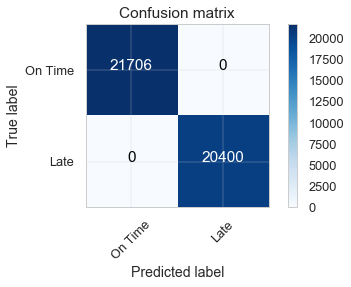

In [418]:
# The second part of Confusion matrix which depends on each model
class_names = [y_label1, y_label2]
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [419]:
TN, FP, FN, TP = cnf_matrix.ravel() # Getting all results from the matrix and calcualte all KPIs
accuracy = (TP + TN) / (TP + TN + FP + FN)
miss_calc_rate = (FP + FN) / (TP + TN + FP + FN)
true_pos_rate = TP / (FN + TP)
false_pos_rate = FP / (TN + FP)
specificity = TN / (TN+FP)
precision = TP/(FP+TP)
prevalence = (FN+TP)/(TP + TN + FP + FN)
class_names = [y_label1, y_label2]

print("True Positives (TP): Correctly predicted %s for %s" % (format(y_label2), TP))
print("True Negatives (TN): Correctly predicted %s for %s" % (format(y_label1), TN))
print("False Positives (FP): Incorrectly predicted that it is %s or Type I error: %s" %(format(y_label2), FP))
print("False Negatives (FN): Incorrectly predicted that it is %s or Type II error: %s" %(format(y_label1), FN))
print("=============================")
print("Overall, how often is the classifier correct or Accuracy? %s" %format(accuracy,'.2f')) 
print("Overall, how often is the classifier incorrect or Misclassification Rate? %s" %format(miss_calc_rate,'.2f')) 
print("When the actual value is positive, how often is the prediction correct \
(Sensitivity or Recall)? %s" %(format(true_pos_rate,'.2f')))
print("When the actual value is negative, how often is the prediction correct \
(Specificity)? %s" %format(specificity,'.2f'))
print("When the actual value is negative, how often is the prediction incorrect \
(False Positive Rate)? %s" %format(false_pos_rate,'.2f'))
print("When a positive value is predicted, how often is the prediction correct \
(Precision)? %s" %format(precision,'.2f'))
print("How often does the yes condition actually occur in our sample (Prevalence)? %s" %format(prevalence,'.2f'))

True Positives (TP): Correctly predicted Late for 20400
True Negatives (TN): Correctly predicted On Time for 21706
False Positives (FP): Incorrectly predicted that it is Late or Type I error: 0
False Negatives (FN): Incorrectly predicted that it is On Time or Type II error: 0
Overall, how often is the classifier correct or Accuracy? 1.00
Overall, how often is the classifier incorrect or Misclassification Rate? 0.00
When the actual value is positive, how often is the prediction correct (Sensitivity or Recall)? 1.00
When the actual value is negative, how often is the prediction correct (Specificity)? 1.00
When the actual value is negative, how often is the prediction incorrect (False Positive Rate)? 0.00
When a positive value is predicted, how often is the prediction correct (Precision)? 1.00
How often does the yes condition actually occur in our sample (Prevalence)? 0.48


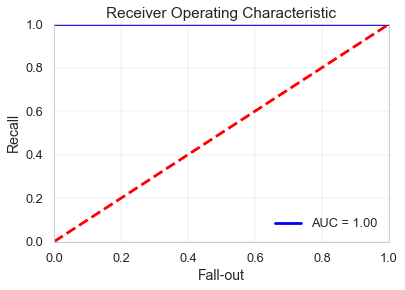

In [420]:
# The dashed line in the following figure is for a classifier that predicts 
# classes randomly; it has an AUC of 0.5. The solid curve is for a classifier 
# that outperforms random guessing:

false_positive_rate, recall, thresholds = roc_curve(test_y, pred_y)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

## Model Training: Gradient Boost

In [421]:
# Here we collect the cross-validation average accuracy 
# for a number of estimators in the range (1, 20). 
# The loss function is the default one (multinomial negative log-likelihood):

Gradient_score_mean = []
max_estimators = 15
for i in range(1, max_estimators):
    score = cross_val_score(GradientBoostingClassifier(n_estimators=i, learning_rate=5.0/float(i)),
                            test_x_small, test_y_small, cv=10, scoring='accuracy').mean()
Gradient_score_mean.append(score)
print("Accuracy: {}".format(Gradient_score_mean))

Accuracy: [0.9209981138836497]


In [422]:
# Start the timer as a measure of the computing effort
start_time = time.time()

# We'll make 20 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 20,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
Gradeboost = ensemble.GradientBoostingClassifier(**params)
Gradeboost.fit(train_x, train_y)

# Predict on test dataset
y_pred = clf.predict(test_x)

# Check the prediction power of the model
pred_y = np.array(clf.predict(test_x))
true_y = np.array(test_y)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

--- 2 seconds ---


Confusion matrix, without normalization
[[21706     0]
 [    0 20400]]


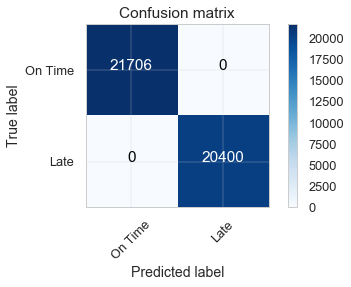

In [423]:
# The second part of Confusion matrix which depends on each model
class_names = [y_label1, y_label2]
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [424]:
TN, FP, FN, TP = cnf_matrix.ravel() # Getting all results from the matrix and calcualte all KPIs
accuracy = (TP + TN) / (TP + TN + FP + FN)
miss_calc_rate = (FP + FN) / (TP + TN + FP + FN)
true_pos_rate = TP / (FN + TP)
false_pos_rate = FP / (TN + FP)
specificity = TN / (TN+FP)
precision = TP/(FP+TP)
prevalence = (FN+TP)/(TP + TN + FP + FN)
class_names = [y_label1, y_label2]

print("True Positives (TP): Correctly predicted %s for %s" % (format(y_label2), TP))
print("True Negatives (TN): Correctly predicted %s for %s" % (format(y_label1), TN))
print("False Positives (FP): Incorrectly predicted that it is %s or Type I error: %s" %(format(y_label2), FP))
print("False Negatives (FN): Incorrectly predicted that it is %s or Type II error: %s" %(format(y_label1), FN))
print("=============================")
print("Overall, how often is the classifier correct or Accuracy? %s" %format(accuracy,'.2f')) 
print("Overall, how often is the classifier incorrect or Misclassification Rate? %s" %format(miss_calc_rate,'.2f')) 
print("When the actual value is positive, how often is the prediction correct \
(Sensitivity or Recall)? %s" %(format(true_pos_rate,'.2f')))
print("When the actual value is negative, how often is the prediction correct \
(Specificity)? %s" %format(specificity,'.2f'))
print("When the actual value is negative, how often is the prediction incorrect \
(False Positive Rate)? %s" %format(false_pos_rate,'.2f'))
print("When a positive value is predicted, how often is the prediction correct \
(Precision)? %s" %format(precision,'.2f'))
print("How often does the yes condition actually occur in our sample (Prevalence)? %s" %format(prevalence,'.2f'))

True Positives (TP): Correctly predicted Late for 20400
True Negatives (TN): Correctly predicted On Time for 21706
False Positives (FP): Incorrectly predicted that it is Late or Type I error: 0
False Negatives (FN): Incorrectly predicted that it is On Time or Type II error: 0
Overall, how often is the classifier correct or Accuracy? 1.00
Overall, how often is the classifier incorrect or Misclassification Rate? 0.00
When the actual value is positive, how often is the prediction correct (Sensitivity or Recall)? 1.00
When the actual value is negative, how often is the prediction correct (Specificity)? 1.00
When the actual value is negative, how often is the prediction incorrect (False Positive Rate)? 0.00
When a positive value is predicted, how often is the prediction correct (Precision)? 1.00
How often does the yes condition actually occur in our sample (Prevalence)? 0.48


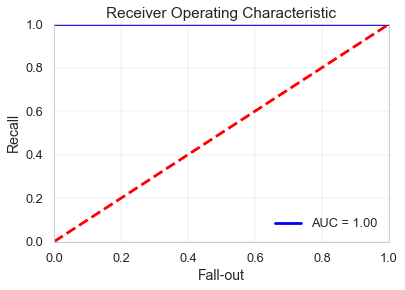

In [425]:
# The dashed line in the following figure is for a classifier that predicts 
# classes randomly; it has an AUC of 0.5. The solid curve is for a classifier 
# that outperforms random guessing:

false_positive_rate, recall, thresholds = roc_curve(test_y, pred_y)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

## Model Training: Support Vector Machine

In [71]:
# Because of high cost of computation cost we do not tune the parameters here
# Otherwise here are the code in case we can afford it

#Start the timer as a measure of the computing effort
start_time = time.time()

# # Initialize and fit the model
svm = SVC(kernel = 'linear', C = 2)
svm.fit(train_x_small, train_y_small)

# Predict on test dataset
y_pred = svm.predict(test_x_small)

# Check the prediction power of the model
pred_y = np.array(svm.predict(test_x_small))
true_y = np.array(test_y_small)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

--- 2210 seconds ---


Confusion matrix, without normalization
[[318 168]
 [217 297]]


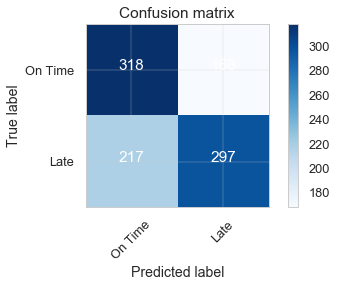

In [75]:
# The second part of Confusion matrix which depends on each model
class_names = [y_label1, y_label2]
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [76]:
TN, FP, FN, TP = cnf_matrix.ravel() # Getting all results from the matrix and calcualte all KPIs
accuracy = (TP + TN) / (TP + TN + FP + FN)
miss_calc_rate = (FP + FN) / (TP + TN + FP + FN)
true_pos_rate = TP / (FN + TP)
false_pos_rate = FP / (TN + FP)
specificity = TN / (TN+FP)
precision = TP/(FP+TP)
prevalence = (FN+TP)/(TP + TN + FP + FN)
class_names = [y_label1, y_label2]

print("True Positives (TP): Correctly predicted %s for %s" % (format(y_label2), TP))
print("True Negatives (TN): Correctly predicted %s for %s" % (format(y_label1), TN))
print("False Positives (FP): Incorrectly predicted that it is %s or Type I error: %s" %(format(y_label2), FP))
print("False Negatives (FN): Incorrectly predicted that it is %s or Type II error: %s" %(format(y_label1), FN))
print("=============================")
print("Overall, how often is the classifier correct or Accuracy? %s" %format(accuracy,'.2f')) 
print("Overall, how often is the classifier incorrect or Misclassification Rate? %s" %format(miss_calc_rate,'.2f')) 
print("When the actual value is positive, how often is the prediction correct \
(Sensitivity or Recall)? %s" %(format(true_pos_rate,'.2f')))
print("When the actual value is negative, how often is the prediction correct \
(Specificity)? %s" %format(specificity,'.2f'))
print("When the actual value is negative, how often is the prediction incorrect \
(False Positive Rate)? %s" %format(false_pos_rate,'.2f'))
print("When a positive value is predicted, how often is the prediction correct \
(Precision)? %s" %format(precision,'.2f'))
print("How often does the yes condition actually occur in our sample (Prevalence)? %s" %format(prevalence,'.2f'))

True Positives (TP): Correctly predicted Late for 297
True Negatives (TN): Correctly predicted On Time for 318
False Positives (FP): Incorrectly predicted that it is Late or Type I error: 168
False Negatives (FN): Incorrectly predicted that it is On Time or Type II error: 217
Overall, how often is the classifier correct or Accuracy? 0.61
Overall, how often is the classifier incorrect or Misclassification Rate? 0.39
When the actual value is positive, how often is the prediction correct (Sensitivity or Recall)? 0.58
When the actual value is negative, how often is the prediction correct (Specificity)? 0.65
When the actual value is negative, how often is the prediction incorrect (False Positive Rate)? 0.35
When a positive value is predicted, how often is the prediction correct (Precision)? 0.64
How often does the yes condition actually occur in our sample (Prevalence)? 0.51


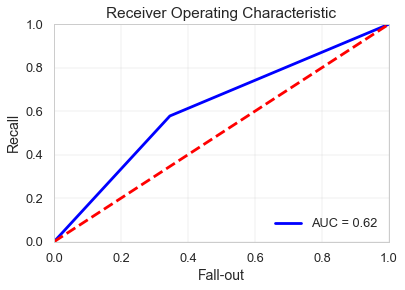

In [77]:
# The dashed line in the following figure is for a classifier that predicts 
# classes randomly; it has an AUC of 0.5. The solid curve is for a classifier 
# that outperforms random guessing:

false_positive_rate, recall, thresholds = roc_curve(test_y_small, pred_y)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

## Conclusion 
In this analysis we lightly touched most of the phases of a typical ML life cycle. We started with data source then did some initial processing such as cleaning, format and quality check, transformation and feature selection.

We continued training some of the majors supervised ML models. Then did model evaluation using cross-validation and calculated some performance metrics for each model. We also optimized most of the hyperparameters. However, if we are aiming to develop ML for real life applications, then we need to strike a balance between ML optimization versus software application. At this stage we should avoid building "blackbox" and instead try to ensure our steps are extensible and modular. Pipeline versioning is one such method. 

The purpose of this ML work was to identify at least one algorithm that can learn from past arrival and departure data and predict future ones. Delayed flights is one of the major business problems for airlines causing significant costs.
Many factors such as natural events or operational shortcomings cause expensive delays for airlines. In addition, they tend to create problems in scheduling and operations for many end-users because of their ripple effects. 

We structured this ML study as a binary classification where time deviation more than 30 minutes was considered as "late". Next, we looked at all airlines and identifid those responsible for 90% of lateness occurance. 
Next, we standardized the dataset and made all categorical data such as airine name as binary data. We ended up having thousands rows of data and almost five thousand columns of features. This was a high dimensional dataset and we used PCA to shrink all of them into 3 features explaining more than 90% of variance in data. After PCA selection we broke the data into 80% training and 20% testing using following algorithms. 


- Decision Tree (99%)
- Random Forest (99%)
- Logistic Regression (61%)
- Naive - Bayes (Bernoulli) (62%)
- KNeighbors Classifier (100%)
- Gradient Boosting Classifier (92%)
- Support Vector Machine (61%)

All algorithms performed great except Logistic Regression, Naive Bayes and SVM. For SMV I used a much smaller sample size because of high computational effort therefore cannot be sure if this low performance is due to small dataset or other issues.